Saving Aerial Photo from Miami Dade County web services

In [11]:
import requests
from pyproj import Transformer

# Defining  AOI center in lon/lat
center_lon = -80.24953543355088
center_lat = 25.83013736691271

# transformer: WGS84 -> EPSG:2236 
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2236", always_xy=True)
cx_feet, cy_feet = transformer.transform(center_lon, center_lat)

# Compute 3 km box in feet
meters_to_feet = 3.28084
half_side_m = 1500.0
half_side_ft = half_side_m * meters_to_feet  

xmin = cx_feet - half_side_ft
xmax = cx_feet + half_side_ft
ymin = cy_feet - half_side_ft
ymax = cy_feet + half_side_ft

# Call the MDC MapServer 
export_url = "https://gisweb.miamidade.gov/arcgis/rest/services/MapCache/MDCImagery/MapServer/export"

# image size
width = 4096
height = 4096

params = {
    "bbox": f"{xmin},{ymin},{xmax},{ymax}",
    "bboxSR": 2236,
    "imageSR": 2236,    
    "size": f"{width},{height}",
    "format": "tiff",   
    "f": "image",     
}
#saving response
response = requests.get(export_url, params=params)
response.raise_for_status()  

with open("orthophoto_3km.tif", "wb") as f:
    f.write(response.content)

print("Saved orthophoto_3km.tif")

#AI Involvement: ChatGPT was used for debugging and code optimization

Saved orthophoto_3km.tif


Georeferencing the orthophoto. The downloaded aerial image is not geo-referenced

In [5]:
import rasterio
from rasterio.transform import Affine

in_path = "orthophoto_3km.tif"
out_path = "orthophoto_3km_georef.tif"

with rasterio.open(in_path) as src:
    arr = src.read()
    height = src.height
    width = src.width
    profile = src.profile

xres = (907935.9877176675 - 898093.4677176675) / width
yres = (549579.4040555587 - 539736.8840555587) / height

transform = Affine(xres, 0, 898093.4677176675, 0, -yres,549579.4040555587)

profile.update({
    "crs": "EPSG:2236",
    "transform": transform
})

with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(arr)

#AI Involvement: ChatGPT was used for debugging and code optimization

c:\Users\Shuvo\anaconda3\envs\dl\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Getting the landuse polygons and simplifying the land use classes into 10 classes

In [3]:
import requests
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import geopandas as gpd

LAND_USE_FEATURESERVER = "https://services.arcgis.com/8Pc9XBTAsYuxx9Ny/arcgis/rest/services/LUMALanduse_gdb/FeatureServer/0"


def fetch_landuse_aoi(xmin, ymin, xmax, ymax, out_crs_epsg=2236):
    geometry = {
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
        "spatialReference": {"wkid": out_crs_epsg},
    }

    params = {
        "where": "1=1",
        "geometry": str(geometry).replace("'", '"'),   
        "geometryType": "esriGeometryEnvelope",
        "inSR": out_crs_epsg,
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "*",
        "f": "geojson",
    }

    resp = requests.get(f"{LAND_USE_FEATURESERVER}/query", params=params)
    resp.raise_for_status()

    data = resp.json()
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf.set_crs(epsg=out_crs_epsg, inplace=True)
    return gdf

landuse_aoi = fetch_landuse_aoi(898093.4677176675, 539736.8840555587,907935.9877176675, 549579.4040555587, out_crs_epsg=2236)
print(landuse_aoi.head())
print(landuse_aoi.shape)
print(len(landuse_aoi['DESCR'].unique()))

def simplify_descr(desc):
    d = str(desc).lower()

    # 1. Water
    if "water" in d or "lakes" in d or "ponds" in d:
        return "WATER"

    # 2. Vacant
    if "vacant" in d:
        return "VACANT"

    # 3. Parks / open space / cemeteries
    if "park" in d or "cemeter" in d:
        return "PARKS_OPEN_SPACE"

    # 4. Transport infrastructure (roads, parking, rail, terminals, drives)
    if ("street" in d or "roads" in d or "railroad" in d
        or "parking" in d or "terminal" in d
        or "bus/truck" in d or "freight" in d
        or "private drives" in d or "right-of-way" in d):
        return "TRANSPORT_INFRA"

    # 5. Industrial
    if "industrial" in d or "junk yard" in d:
        return "INDUSTRIAL"

    # 6. Utilities / infrastructure
    if ("sewerage" in d or "treatment plant" in d or "electric power" in d
        or "generator" in d or "substation" in d or "communications" in d
        or "oil and gas storage" in d or "tank farms" in d
        or "motor pools" in d or "maintenance and storage yards" in d):
        return "UTILITIES_INFRA"

    # 7. Civic / institutional
    if ("school" in d or "hospital" in d or "clinic" in d or "medical" in d
        or "nursing home" in d or "assisted living" in d
        or "social services" in d or "charitable" in d
        or "governmental/public administration" in d
        or "houses of worship" in d or "religious" in d):
        return "CIVIC_INSTITUTIONAL"

    # 8. Residential 
    if "office" in d and "residential" in d:
        return "COMMERCIAL_MIXED"

    if ("single-family" in d or "two-family" in d or "multi-family" in d
        or "mobile home" in d or "residential sf" in d
        or "residential mf" in d
        or ("residential" in d and "transient" not in d)):
        return "RESIDENTIAL"

    # 9. Commercial / mixed
    if ("sales and services" in d or "shopping center" in d
        or "strip commercial" in d or "office building" in d
        or "business" in d or "hotel" in d or "motel" in d
        or "transient-residential" in d):
        return "COMMERCIAL_MIXED"

    # Fallback
    return "OTHER"
landuse_aoi["simple_class"] = landuse_aoi["DESCR"].apply(simplify_descr)

print(landuse_aoi["simple_class"].value_counts())
print("Num simplified classes:", landuse_aoi["simple_class"].nunique())

simple_classes = sorted(landuse_aoi["simple_class"].unique())
class_to_id = {c: i for i, c in enumerate(simple_classes)}
id_to_class = {i: c for c, i in class_to_id.items()}

landuse_aoi["class_id"] = landuse_aoi["simple_class"].map(class_to_id)

print("Class mapping:", class_to_id)
print(landuse_aoi[["DESCR", "simple_class", "class_id"]].head())

import json
with open("landuse_class_mapping.json", "w") as f:
    json.dump(class_to_id, f, indent=2)

# After adding simple_class and class_id
landuse_aoi.to_file(
    "landuse_3km_simplified.gpkg",
    layer="landuse_3km_simplified",
    driver="GPKG"
)

#AI Involvement: ChatGPT was used for debugging and code optimization

                                            geometry  OBJECTID   LU  \
0  POLYGON ((-80.246 25.842, -80.247 25.842, -80....     80135  339   
1  POLYGON ((-80.248 25.827, -80.248 25.827, -80....       161   10   
2  POLYGON ((-80.241 25.817, -80.242 25.817, -80....     52844   20   
3  POLYGON ((-80.241 25.839, -80.24 25.838, -80.2...     80198  339   
4  POLYGON ((-80.26 25.839, -80.26 25.839, -80.26...     49449   20   

                                              DESCR  \
0                              Industrial Extensive   
1  Single-Family, Med.-Density (2-5 DU/Gross Acre).   
2                            Two-Family (Duplexes).   
3                              Industrial Extensive   
4                            Two-Family (Duplexes).   

                               GlobalID   Shape__Area  Shape__Length  
0  9baa3b14-e9e8-452c-817d-81ad37b70c91   8942.513672     469.201212  
1  b6277478-aebf-4b34-9d9e-91337b70604b   1113.134766     138.009223  
2  ef5ed7fa-7c7c-44b2-922f-b1

Rasterizing the landuse polygons

In [12]:
import rasterio
import geopandas as gpd
from rasterio import features
import numpy as np

ortho_path = "orthophoto_3km_georef.tif"
landuse_path = "landuse_3km_simplified.gpkg"

# Load orthophoto
with rasterio.open(ortho_path) as src:
    ortho_img = src.read()
    ortho_meta = src.meta.copy()
    transform = src.transform
    height = src.height
    width = src.width
    raster_crs = src.crs
    raster_bounds = src.bounds

print("Ortho shape:", ortho_img.shape)
print("Raster CRS:", raster_crs)
print("Raster bounds:", raster_bounds)

# Load land use
landuse_aoi = gpd.read_file(landuse_path, layer="landuse_3km_simplified")
print("Original landuse CRS:", landuse_aoi.crs)
print("Original landuse bounds:", landuse_aoi.total_bounds)

landuse_aoi = landuse_aoi.set_crs(epsg=4326, allow_override=True)

# Reproject to raster CRS (EPSG:2236)
if landuse_aoi.crs != raster_crs:
    landuse_aoi = landuse_aoi.to_crs(raster_crs)

print("Reprojected landuse CRS:", landuse_aoi.crs)
print("Reprojected landuse bounds:", landuse_aoi.total_bounds)
#class id
assert "class_id" in landuse_aoi.columns, "class_id column missing"
print("class_id nunique:", landuse_aoi["class_id"].nunique())

#shape list
shape_list = []
for geom, cid in zip(landuse_aoi.geometry, landuse_aoi["class_id"]):
    if geom is None or geom.is_empty:
        continue
    if cid is None or (isinstance(cid, float) and np.isnan(cid)):
        continue
    shape_list.append((geom, int(cid)))

print("Number of shapes to rasterize:", len(shape_list))

label_raster = features.rasterize(
    shapes=shape_list,
    out_shape=(height, width),
    transform=transform,
    fill=-1,
    dtype="int16",
)

print("Unique labels after rasterize:", np.unique(label_raster))

label_meta = ortho_meta.copy()
label_meta.update({
    "driver": "GTiff",   # critical!
    "count": 1,
    "dtype": "int16",
    "nodata": -1,
})

label_path = "landuse_labels_3km.tif"

with rasterio.open(label_path, "w", **label_meta) as dst:
    dst.write(label_raster, 1)

print("Saved label raster to:", label_path)

# checking labels
with rasterio.open(label_path) as src:
    labels = src.read(1)
    print("dtype:", labels.dtype)
    print("Unique values:", np.unique(labels))

#AI Involvement: ChatGPT was used for debugging and code optimization

Ortho shape: (4, 4096, 4096)
Raster CRS: EPSG:2236
Raster bounds: BoundingBox(left=898093.4677176675, bottom=539736.8840555587, right=907935.9877176675, top=549579.4040555587)
Original landuse CRS: EPSG:2236
Original landuse bounds: [-80.27469963  25.80816925 -80.22400671  25.85393617]
Reprojected landuse CRS: PROJCS["NAD83 / Florida East (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",24.3333333333333],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.999941177],PARAMETER["false_easting",656166.667],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2236"]]
Reprojected landu

Visualizing land use map

dtype: int16
Unique values: [0 1 2 3 4 5 6 7 8 9]
Value counts:
value 0: 399971 pixels
value 1: 774012 pixels
value 2: 4737439 pixels
value 3: 6919 pixels
value 4: 669430 pixels
value 5: 4521383 pixels
value 6: 4965790 pixels
value 7: 88931 pixels
value 8: 588348 pixels
value 9: 24993 pixels


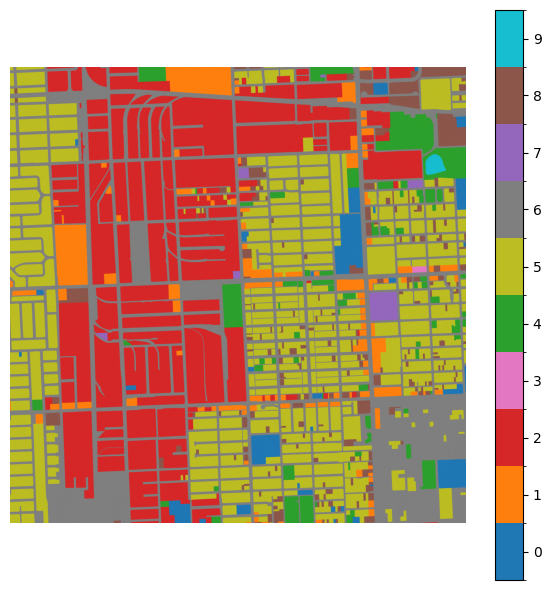

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


#Load label raster
label_path = "landuse_labels_3km.tif"

with rasterio.open(label_path) as src:
    labels = src.read(1)  # first (and only) band
    print("dtype:", labels.dtype)
    unique_vals = np.unique(labels)
    print("Unique values:", unique_vals)

    vals, counts = np.unique(labels, return_counts=True)
    print("Value counts:")
    for v, c in zip(vals, counts):
        print(f"value {v}: {c} pixels")

#integer type
labels = labels.astype(int)

# Masking nodata for plotting 
masked = np.ma.masked_equal(labels, -1)


# 2. Define class mapping and colors

class_to_id = {
    'CIVIC_INSTITUTIONAL': 0,'COMMERCIAL_MIXED': 1,'INDUSTRIAL': 2,'OTHER':3,'PARKS_OPEN_SPACE':4,
    'RESIDENTIAL':5,'TRANSPORT_INFRA':6,'UTILITIES_INFRA': 7,'VACANT':8,'WATER': 9}

class_colors = {'CIVIC_INSTITUTIONAL': "#1f77b4" ,  'COMMERCIAL_MIXED': "#ff7f0e", 'INDUSTRIAL': "#d62728", 'PARKS_OPEN_SPACE':  "#2ca02c",  'RESIDENTIAL':         "#bcbd22",   'TRANSPORT_INFRA':     "#7f7f7f",  'UTILITIES_INFRA':     "#9467bd", 
               'VACANT': "#8c564b", 'WATER': "#17becf",  'OTHER': "#e377c2" }

#Sorting classes by numeric id (0..9)
sorted_classes = sorted(class_to_id.items(), key=lambda kv: kv[1])

# Building color list in order of class_id
color_list = [class_colors[cname] for cname, cid in sorted_classes]

# Building discrete colormap 
cmap = ListedColormap(color_list)
max_id = max(class_to_id.values())

# boundaries: [-0.5, 0.5, 1.5, ..., max_id+0.5]
boundaries = np.arange(-0.5, max_id + 1.5, 1)
norm = BoundaryNorm(boundaries, cmap.N)

# Plotting
plt.figure(figsize=(6, 6))
im = plt.imshow(masked, cmap=cmap, norm=norm)
plt.axis("off")

# Colorbar with integer ticks (0..max_id)
cbar = plt.colorbar(im, boundaries=boundaries, ticks=np.arange(0, max_id + 1))
cbar.ax.set_yticklabels([str(i) for i in range(0, max_id + 1)])
plt.tight_layout()
plt.show()


#AI Involvement: ChatGPT was used for debugging and code optimization

Making Tiles of 128 x 128 size. The ortho photo tiles are saved into an image folder as npy file. And the corresponding  labels are also saved as npy file for each tile

In [5]:
import os
import json
import numpy as np
import rasterio
import pandas as pd

ortho_path = "orthophoto_3km_georef.tif"
label_path = "landuse_labels_3km.tif"

out_img_dir = "tiles/images"
out_lbl_dir = "tiles/labels"
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_lbl_dir, exist_ok=True)

tile_size = 128
min_valid_ratio = 0.1   

meta_rows = []

with rasterio.open(ortho_path) as src_img, rasterio.open(label_path) as src_lbl:
    assert src_img.width == src_lbl.width
    assert src_img.height == src_lbl.height
    assert src_img.crs == src_lbl.crs
    assert src_img.transform == src_lbl.transform

    C = src_img.count
    H = src_img.height
    W = src_img.width

    tile_id = 0
    for y in range(0, H - tile_size + 1, tile_size):
        iy = y // tile_size
        for x in range(0, W - tile_size + 1, tile_size):
            ix = x // tile_size

            # reading window
            img_tile = src_img.read(window=((y, y + tile_size), (x, x + tile_size)))  
            lbl_tile = src_lbl.read(1, window=((y, y + tile_size), (x, x + tile_size)))  

            # skipping tiles that are mostly nodata (-1)
            valid = (lbl_tile != -1)
            valid_ratio = valid.mean()
            if valid_ratio < min_valid_ratio:
                continue

            img_path = os.path.join(out_img_dir, f"img_{tile_id:05d}.npy")
            lbl_path = os.path.join(out_lbl_dir, f"lbl_{tile_id:05d}.npy")

            np.save(img_path, img_tile.astype(np.float32))
            np.save(lbl_path, lbl_tile.astype(np.int16))

            meta_rows.append({"tile_id": tile_id, "img_path": img_path, "lbl_path": lbl_path,"x_pix": x,
                "y_pix": y, "ix": ix,"iy": iy,"valid_ratio": float(valid_ratio),})

            tile_id += 1

meta_df = pd.DataFrame(meta_rows)
meta_df.to_csv("tiles/tiles_meta_raw.csv", index=False)
print("Saved", len(meta_df), "tiles to tiles/ and metadata to tiles/tiles_meta_raw.csv")


#AI Involvement: ChatGPT was used for debugging and code optimization

Saved 1024 tiles to tiles/ and metadata to tiles/tiles_meta_raw.csv


Train-Test-Validation Split. The tiles metadata were previously saved in a csv file. The train-test split is simply adding a row with a label of either 'train'/'test'/'validation' for each datapoint

In [6]:
import pandas as pd

meta = pd.read_csv("tiles/tiles_meta_raw.csv")

# iy is the row index (0 at top)
ny = meta["iy"].max() + 1
print("Number of rows:", ny)

# defining fractions for vertical split 
test_frac  = 0.2  
val_frac   = 0.1   
test_y_max = int(ny * test_frac)        
val_y_max  = int(ny * (test_frac + val_frac))  

def assign_split(iy):
    if iy < test_y_max:
        return "test"    
    elif iy < val_y_max:
        return "val"    
    else:
        return "train"  

meta["split"] = meta["iy"].apply(assign_split)

print(meta["split"].value_counts())
meta.to_csv("tiles/tiles_meta_split.csv", index=False)
print("Saved row-wise split to tiles/tiles_meta_split.csv")

#AI Involvement: ChatGPT was used for debugging and code optimization

Number of rows: 32
split
train    736
test     192
val       96
Name: count, dtype: int64
Saved row-wise split to tiles/tiles_meta_split.csv


Balancing the train set using RandomOverSampler

In [7]:

import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

META_IN = "tiles/tiles_meta_split.csv"                 
META_OUT = "tiles/tiles_meta_split_balanced_prop.csv" 

# Max factor by which any class's tile count can grow
CAP_FACTOR = 3.0   

def main():
    meta = pd.read_csv(META_IN)

    train_meta = meta[meta["split"] == "train"].reset_index(drop=True)
    val_meta   = meta[meta["split"] == "val"].reset_index(drop=True)
    test_meta  = meta[meta["split"] == "test"].reset_index(drop=True)

    #computiing dominant class + per-class pixel counts ----
    dom_classes = []
    class_pixel_counts = {}  

    print("Scanning train tiles to compute dominant class and pixel counts...")
    for i, row in train_meta.iterrows():
        lbl = np.load(row["lbl_path"])  
        lbl = lbl[lbl >= 0]            

        if lbl.size == 0:
            dom_classes.append(-1)
            continue

        vals, counts = np.unique(lbl, return_counts=True)

        # dominant class for this tile (most pixels)
        dom_c = int(vals[counts.argmax()])
        dom_classes.append(dom_c)

        # pixel counts per class
        for v, c in zip(vals, counts):
            v = int(v)
            class_pixel_counts[v] = class_pixel_counts.get(v, 0) + int(c)

    train_meta["dom_class"] = dom_classes
    # drop tiles with no valid labels at all
    train_meta = train_meta[train_meta["dom_class"] >= 0].reset_index(drop=True)

    # sort classes 
    class_ids = sorted(class_pixel_counts.keys())
    print("\nTotal pixel counts per class in TRAIN:")
    for cid in class_ids:
        print(f"  class {cid}: {class_pixel_counts[cid]} pixels")

    # defining target number of tiles per class
    max_pixels = max(class_pixel_counts.values())
    print("\nMax pixels among classes:", max_pixels)

    # current number of tiles per dominant class
    tile_counts = train_meta["dom_class"].value_counts().to_dict()
    print("\nCurrent tile counts per dominant class:")
    for cid in sorted(tile_counts.keys()):
        print(f"  class {cid}: {tile_counts[cid]} tiles")

    sampling_strategy = {}
    for cid in class_ids:
        pixels_c = class_pixel_counts[cid]
        base_n_tiles = tile_counts.get(cid, 0)

        if pixels_c == 0 or base_n_tiles == 0:
            continue

        # how many times smaller than the max-pixel class
        multiplier = max_pixels / float(pixels_c)

        # target tiles = base tiles * multiplier
        target_tiles = int(round(base_n_tiles * multiplier))

        # capping to avoid extreme upsampling
        max_cap = int(base_n_tiles * CAP_FACTOR)
        target_tiles = min(target_tiles, max_cap)

        # only upsample or keep same
        target_tiles = max(target_tiles, base_n_tiles)

        sampling_strategy[cid] = target_tiles

    print("\nSampling strategy (target tiles per class, proportionally increased):")
    for cid in sorted(sampling_strategy.keys()):
        print(f"  class {cid}: from {tile_counts.get(cid, 0)} -> {sampling_strategy[cid]} tiles")

    # RandomOverSampler
    X = train_meta.index.values.reshape(-1, 1)
    y = train_meta["dom_class"].values

    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_res, y_res = ros.fit_resample(X, y)

    print("\nResampled train dominant-class distribution:")
    unique, counts = np.unique(y_res, return_counts=True)
    for cid, cnt in zip(unique, counts):
        print(f"  class {cid}: {cnt} tiles")

    # building balanced train_meta by duplicating rows ----
    idx_resampled = X_res.ravel()
    train_meta_balanced = train_meta.iloc[idx_resampled].reset_index(drop=True)
    train_meta_balanced = train_meta_balanced.drop(columns=["dom_class"])

    # combine with unchanged val,test 
    balanced_meta = pd.concat(
        [train_meta_balanced, val_meta, test_meta],
        ignore_index=True)

    balanced_meta.to_csv(META_OUT, index=False)
    print(f"\nSaved proportionally balanced metadata to {META_OUT}")
    print("New train size:", len(train_meta_balanced))
    print("Val size:", len(val_meta), "Test size:", len(test_meta))


if __name__ == "__main__":
    main()

#AI Involvement: ChatGPT was used for debugging and code optimization

Scanning train tiles to compute dominant class and pixel counts...

Total pixel counts per class in TRAIN:
  class 0: 355151 pixels
  class 1: 546397 pixels
  class 2: 2854875 pixels
  class 3: 6919 pixels
  class 4: 347258 pixels
  class 5: 3728719 pixels
  class 6: 3798737 pixels
  class 7: 70541 pixels
  class 8: 350027 pixels

Max pixels among classes: 3798737

Current tile counts per dominant class:
  class 0: 22 tiles
  class 1: 29 tiles
  class 2: 222 tiles
  class 4: 14 tiles
  class 5: 310 tiles
  class 6: 128 tiles
  class 7: 4 tiles
  class 8: 7 tiles

Sampling strategy (target tiles per class, proportionally increased):
  class 0: from 22 -> 66 tiles
  class 1: from 29 -> 87 tiles
  class 2: from 222 -> 295 tiles
  class 4: from 14 -> 42 tiles
  class 5: from 310 -> 316 tiles
  class 6: from 128 -> 128 tiles
  class 7: from 4 -> 12 tiles
  class 8: from 7 -> 21 tiles

Resampled train dominant-class distribution:
  class 0: 66 tiles
  class 1: 87 tiles
  class 2: 295 tiles
 

Dataset Loader

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A

class LandUseTileDataset(Dataset):
    def __init__(self, meta_csv, split, augment=False):
        self.meta = pd.read_csv(meta_csv)
        self.meta = self.meta[self.meta["split"] == split].reset_index(drop=True)
        self.split = split
        self.augment = augment

        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ])
        else:
            self.transform = None

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        img = np.load(row["img_path"])   
        lbl = np.load(row["lbl_path"])  

        if img.shape[0] > 3:
            img = img[:3, :, :]

        img_hwc = np.transpose(img, (1, 2, 0))  

        if self.transform is not None:
            augmented = self.transform(image=img_hwc, mask=lbl)
            img_hwc = augmented["image"]
            lbl = augmented["mask"]

        img = np.transpose(img_hwc, (2, 0, 1))  

        if img.max() > 1.5:
            img = img / 255.0

        mean = np.array([0.485, 0.456, 0.406])[:, None, None]
        std  = np.array([0.229, 0.224, 0.225])[:, None, None]
        img = (img - mean) / std

        # labels: nodata (-1) to 255
        lbl = lbl.astype(np.int64)
        lbl[lbl < 0] = 255

        img = torch.from_numpy(img.astype(np.float32))
        lbl = torch.from_numpy(lbl)

        return img, lbl

def make_loaders(meta_csv, batch_size=8, num_workers=0):
    meta = pd.read_csv(meta_csv, header=0)

    # inferring n_classes from ALL label tiles
    max_label = -1
    for p in meta["lbl_path"]:
        arr = np.load(p)
        arr = arr[arr >= 0] 
        if arr.size > 0:
            m = int(arr.max())
            if m > max_label:
                max_label = m
    n_classes = max_label + 1
    print("Inferred n_classes from label files:", n_classes)

    train_ds = LandUseTileDataset(meta_csv, split="train", augment=True)
    val_ds   = LandUseTileDataset(meta_csv, split="val", augment=False)
    test_ds  = LandUseTileDataset(meta_csv, split="test", augment=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, n_classes

#AI Involvement: ChatGPT was used for debugging and code optimization

Training

Using device: cuda
Inferred n_classes from label files: 10
n_classes: 10


c:\Users\Shuvo\anaconda3\envs\dl\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Train loss: 1.5706, overall acc: 0.4376
Val   loss: 1.2404, overall acc: 0.6821
Saved new best model with val acc: 0.6820894877115885

Epoch 2/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Train loss: 1.4433, overall acc: 0.5380
Val   loss: 1.1392, overall acc: 0.7191
Saved new best model with val acc: 0.7191117604573568

Epoch 3/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Train loss: 1.4228, overall acc: 0.5377
Val   loss: 1.1163, overall acc: 0.6746

Epoch 4/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


Train loss: 1.4033, overall acc: 0.5378
Val   loss: 1.0806, overall acc: 0.7304
Saved new best model with val acc: 0.7303549448649088

Epoch 5/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


Train loss: 1.3863, overall acc: 0.5260
Val   loss: 1.0428, overall acc: 0.7495
Saved new best model with val acc: 0.7495174407958984

Epoch 6/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


Train loss: 1.3794, overall acc: 0.5348
Val   loss: 1.0790, overall acc: 0.7457

Epoch 7/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Train loss: 1.3738, overall acc: 0.5275
Val   loss: 1.1109, overall acc: 0.7449

Epoch 8/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Train loss: 1.3396, overall acc: 0.5561
Val   loss: 1.0840, overall acc: 0.6712

Epoch 9/40
Current LR: 0.005


val: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Train loss: 1.3285, overall acc: 0.5615
Val   loss: 1.2392, overall acc: 0.7341

Epoch 10/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


Train loss: 1.3119, overall acc: 0.5607
Val   loss: 0.9277, overall acc: 0.7738
Saved new best model with val acc: 0.7737700144449869

Epoch 11/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


Train loss: 1.3057, overall acc: 0.5626
Val   loss: 0.8893, overall acc: 0.7621

Epoch 12/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Train loss: 1.2947, overall acc: 0.5731
Val   loss: 0.9003, overall acc: 0.7603

Epoch 13/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


Train loss: 1.2764, overall acc: 0.5801
Val   loss: 0.9587, overall acc: 0.7319

Epoch 14/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Train loss: 1.2718, overall acc: 0.5690
Val   loss: 1.0572, overall acc: 0.7013

Epoch 15/40
Current LR: 0.0025


val: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


Train loss: 1.2810, overall acc: 0.5822
Val   loss: 0.9991, overall acc: 0.7655

Epoch 16/40
Current LR: 0.00125


val: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Train loss: 1.2506, overall acc: 0.5863
Val   loss: 0.9596, overall acc: 0.7865
Saved new best model with val acc: 0.7864977518717448

Epoch 17/40
Current LR: 0.00125


val: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Train loss: 1.2382, overall acc: 0.5890
Val   loss: 0.8949, overall acc: 0.7623

Epoch 18/40
Current LR: 0.00125


val: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


Train loss: 1.2221, overall acc: 0.5965
Val   loss: 1.1225, overall acc: 0.6765

Epoch 19/40
Current LR: 0.00125


val: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


Train loss: 1.2176, overall acc: 0.5969
Val   loss: 1.0405, overall acc: 0.7440

Epoch 20/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


Train loss: 1.2086, overall acc: 0.5933
Val   loss: 0.8887, overall acc: 0.7848

Epoch 21/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


Train loss: 1.2200, overall acc: 0.5954
Val   loss: 0.9072, overall acc: 0.7803

Epoch 22/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


Train loss: 1.1926, overall acc: 0.5959
Val   loss: 0.9013, overall acc: 0.7728

Epoch 23/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


Train loss: 1.2281, overall acc: 0.5895
Val   loss: 0.9525, overall acc: 0.7729

Epoch 24/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Train loss: 1.1992, overall acc: 0.5948
Val   loss: 0.8626, overall acc: 0.7878
Saved new best model with val acc: 0.7877991994222006

Epoch 25/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


Train loss: 1.2035, overall acc: 0.5977
Val   loss: 0.8847, overall acc: 0.7766

Epoch 26/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


Train loss: 1.1929, overall acc: 0.6031
Val   loss: 0.8711, overall acc: 0.7705

Epoch 27/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


Train loss: 1.1747, overall acc: 0.6017
Val   loss: 0.8664, overall acc: 0.7898
Saved new best model with val acc: 0.7898216247558594

Epoch 28/40
Current LR: 0.000625


val: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Train loss: 1.1735, overall acc: 0.6030
Val   loss: 0.9377, overall acc: 0.7707

Epoch 29/40
Current LR: 0.0003125


val: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


Train loss: 1.1640, overall acc: 0.6089
Val   loss: 0.8469, overall acc: 0.7831

Epoch 30/40
Current LR: 0.0003125


val: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


Train loss: 1.1276, overall acc: 0.6251
Val   loss: 0.8901, overall acc: 0.7733

Epoch 31/40
Current LR: 0.0003125


val: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


Train loss: 1.1295, overall acc: 0.6192
Val   loss: 0.9028, overall acc: 0.7542

Epoch 32/40
Current LR: 0.0003125


val: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


Train loss: 1.1436, overall acc: 0.6225
Val   loss: 0.9098, overall acc: 0.7508

Epoch 33/40
Current LR: 0.0003125


val: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Train loss: 1.1226, overall acc: 0.6221
Val   loss: 0.8993, overall acc: 0.7783

Epoch 34/40
Current LR: 0.00015625


val: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


Train loss: 1.1237, overall acc: 0.6205
Val   loss: 0.8870, overall acc: 0.7629

Epoch 35/40
Current LR: 0.00015625


val: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Train loss: 1.0815, overall acc: 0.6364
Val   loss: 0.8857, overall acc: 0.7569

Epoch 36/40
Current LR: 0.00015625


val: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


Train loss: 1.1242, overall acc: 0.6270
Val   loss: 0.8685, overall acc: 0.7690

Epoch 37/40
Current LR: 0.00015625


val: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


Train loss: 1.1199, overall acc: 0.6289
Val   loss: 0.9197, overall acc: 0.7554

Epoch 38/40
Current LR: 7.8125e-05


val: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


Train loss: 1.0811, overall acc: 0.6397
Val   loss: 0.9184, overall acc: 0.7573

Epoch 39/40
Current LR: 7.8125e-05


val: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


Train loss: 1.0896, overall acc: 0.6336
Val   loss: 0.8994, overall acc: 0.7627

Epoch 40/40
Current LR: 7.8125e-05


val: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


Train loss: 1.0770, overall acc: 0.6407
Val   loss: 0.8876, overall acc: 0.7624
Saved curves: loss_curve.png, accuracy_curve.png, lr_curve.png


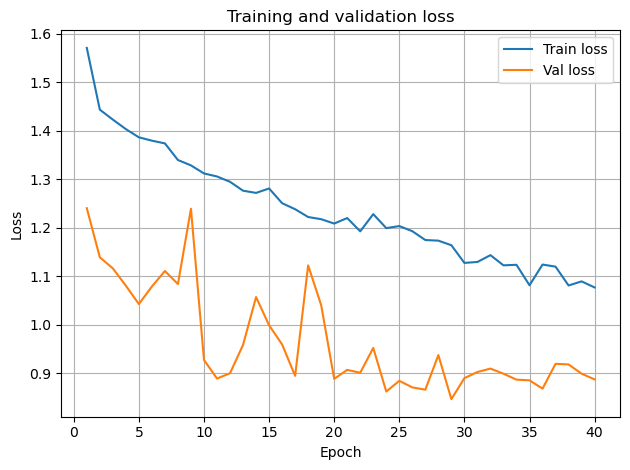

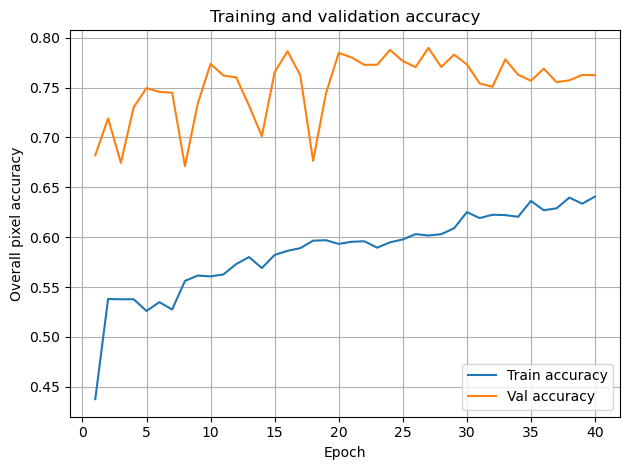

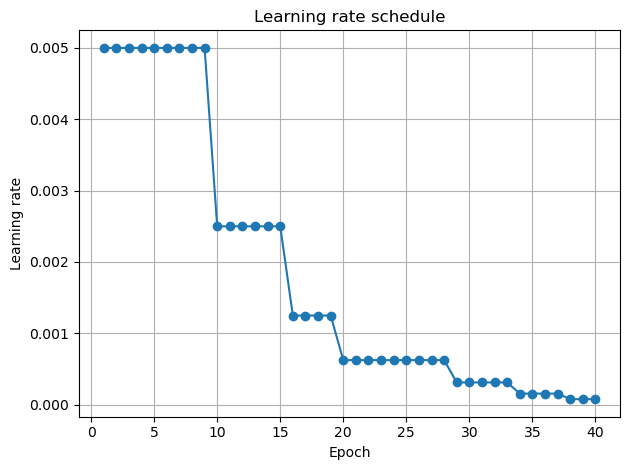

In [9]:

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt



def compute_metrics(logits, labels, n_classes):
    with torch.no_grad():
        preds = logits.argmax(dim=1) 
        mask = (labels != 255)

        correct = (preds[mask] == labels[mask]).sum().item()
        total = mask.sum().item()
        overall_acc = correct / total if total > 0 else 0.0

        per_class_correct = torch.zeros(n_classes, dtype=torch.long, device=preds.device)
        per_class_total   = torch.zeros(n_classes, dtype=torch.long, device=preds.device)

        for c in range(n_classes):
            class_mask = (labels == c)
            per_class_correct[c] = (preds[class_mask] == labels[class_mask]).sum()
            per_class_total[c]   = class_mask.sum()

        per_class_acc = []
        for c in range(n_classes):
            if per_class_total[c] > 0:
                per_class_acc.append((c, (per_class_correct[c] / per_class_total[c]).item()))
            else:
                per_class_acc.append((c, None))

    return overall_acc, per_class_acc


def run_epoch(model, loader, criterion, optimizer, device, n_classes, train=True):
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    all_acc = []

    for imgs, labels in tqdm(loader, desc="train" if train else "val"):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        if train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)
        epoch_loss += loss.item() * imgs.size(0)

        overall_acc, _ = compute_metrics(logits, labels, n_classes)
        all_acc.append(overall_acc)

        if train:
            loss.backward()
            optimizer.step()

    epoch_loss /= len(loader.dataset)
    mean_acc = sum(all_acc) / len(all_acc) if all_acc else 0.0
    return epoch_loss, mean_acc


#HYPERPARAMETERS 
ENCODER_NAME = "resnet50"         
ENCODER_WEIGHTS = "imagenet"      
FREEZE_ENCODER = True           
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4            
BATCH_SIZE = 16
NUM_EPOCHS = 40
NUM_WORKERS = 0              
USE_SCHEDULER = True


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    #data
    meta_csv = r"tiles/tiles_meta_split_balanced_prop.csv"

    train_loader, val_loader, test_loader, n_classes = make_loaders(
        meta_csv, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
    )
    print("n_classes:", n_classes)

    # model
    model = smp.Unet(
        encoder_name=ENCODER_NAME,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=n_classes,
    ).to(device)

    if FREEZE_ENCODER:
        for p in model.encoder.parameters():
            p.requires_grad = False
        #unfreeze last few layers
        for name, p in list(model.encoder.named_parameters())[-20:]:
            p.requires_grad = True

    criterion = nn.CrossEntropyLoss(ignore_index=255)

    optimizer = Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )

    if USE_SCHEDULER:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=3,
            verbose=True,
        )
    else:
        scheduler = None

    # training loop
    best_val_acc = 0.0
    history = {"train_loss": [],"val_loss": [], "train_acc": [],"val_acc": [],"lr": []}

    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
        current_lr = optimizer.param_groups[0]["lr"]
        print("Current LR:", current_lr)

        history["lr"].append(current_lr)  # <-- store LR each epoch

        train_loss, train_acc = run_epoch(
            model, train_loader, criterion, optimizer, device, n_classes, train=True
        )
        val_loss, val_acc = run_epoch(
            model, val_loader, criterion, optimizer, device, n_classes, train=False
        )

        print(f"Train loss: {train_loss:.4f}, overall acc: {train_acc:.4f}")
        print(f"Val   loss: {val_loss:.4f}, overall acc: {val_acc:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step(val_loss)  

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "unet_best.pth")
            print("Saved new best model with val acc:", best_val_acc)

    # PLOTS AFTER TRAINING
    epochs = range(1, NUM_EPOCHS + 1)

    # Loss curve
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"],   label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_curve.png", dpi=150)

    # Accuracy curve
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Train accuracy")
    plt.plot(epochs, history["val_acc"],   label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Overall pixel accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("accuracy_curve.png", dpi=150)

    # Learning rate curve
    plt.figure()
    plt.plot(epochs, history["lr"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Learning rate")
    plt.title("Learning rate schedule")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("lr_curve.png", dpi=150)

    print("Saved curves: loss_curve.png, accuracy_curve.png, lr_curve.png")


if __name__ == "__main__":
    main()

#AI Involvement: ChatGPT was used for debugging and code optimization

Testing

Using device: cuda
Inferred n_classes from label files: 10
n_classes: 10
Test batches: 24


C:\Users\Shuvo\AppData\Local\Temp\ipykernel_26960\1254853843.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_WEIGHTS_PATH, map_location=device)


=== TEST SET METRICS ===
Overall pixel accuracy: 0.6810
Macro precision:0.4363
Macro recall:0.3502
Macro F1:0.4423

Per-class metrics:
   class_id  accuracy  precision    recall        f1  support_true  support_pred
0         0  0.058806   0.013779  0.058806  0.022326         24147        103058
1         1  0.000666   0.066667  0.000666  0.001320        190565          1905
2         2  0.905566   0.740463  0.905566  0.814734       1299263       1588963
3         3       NaN        NaN       NaN       NaN             0             0
4         4  0.361610   0.328036  0.361610  0.344006        210680        232243
5         5  0.765989   0.755158  0.765989  0.760535        418737        424743
6         6  0.708738   0.713582  0.708738  0.711151        800248        794816
7         7  0.000000        NaN  0.000000       NaN          1117             0
8         8  0.000000        NaN  0.000000       NaN        200971             0
9         9       NaN        NaN       NaN       NaN  

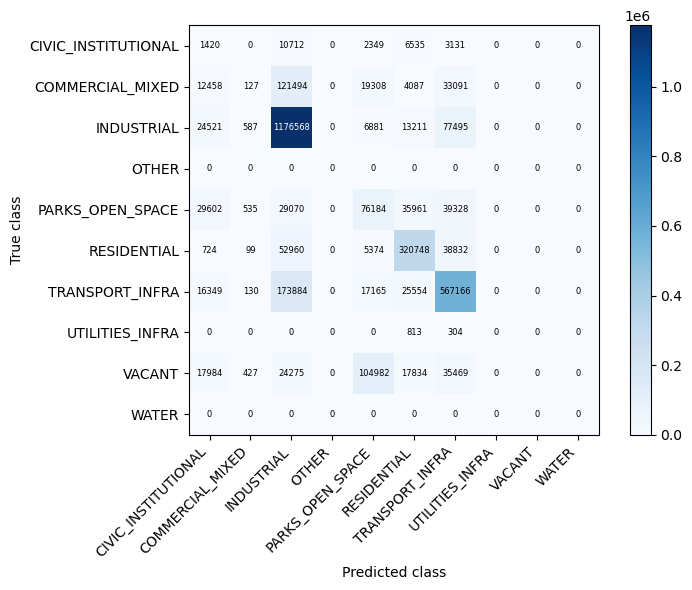

In [10]:

import os
import json
import numpy as np
import torch
import segmentation_models_pytorch as smp
import pandas as pd
import matplotlib.pyplot as plt


ENCODER_NAME = "resnet50"     
ENCODER_WEIGHTS = None        
MODEL_WEIGHTS_PATH = "unet_best.pth"
META_CSV = r"tiles/tiles_meta_split_balanced_prop.csv"

BATCH_SIZE_TEST = 8
NUM_WORKERS_TEST = 0          


def build_model(n_classes, device):
    model = smp.Unet(
        encoder_name=ENCODER_NAME,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=n_classes,
    ).to(device)

    if not os.path.exists(MODEL_WEIGHTS_PATH):
        raise FileNotFoundError(f"Model weights not found: {MODEL_WEIGHTS_PATH}")

    state = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model


def accumulate_confusion(conf_mat, true_labels, pred_labels, n_classes):

    true = true_labels.astype(np.int64)
    pred = pred_labels.astype(np.int64)
    idx = true * n_classes + pred
    binc = np.bincount(idx, minlength=n_classes * n_classes)
    conf_mat += binc.reshape((n_classes, n_classes))
    return conf_mat


def compute_metrics_from_confusion(conf_mat):

    n_classes = conf_mat.shape[0]
    tp = np.diag(conf_mat)
    support_true = conf_mat.sum(axis=1)  
    support_pred = conf_mat.sum(axis=0) 
    total = conf_mat.sum()

    overall_acc = tp.sum() / total if total > 0 else 0.0

    per_class_records = []
    for c in range(n_classes):
        st = support_true[c]
        sp = support_pred[c]
        tpc = tp[c]

        acc_c = tpc / st if st > 0 else None
        prec_c = tpc / sp if sp > 0 else None
        rec_c = tpc / st if st > 0 else None

        if prec_c is not None and rec_c is not None and (prec_c + rec_c) > 0:
            f1_c = 2 * prec_c * rec_c / (prec_c + rec_c)
        else:
            f1_c = None

        per_class_records.append({
            "class_id": c,
            "accuracy": acc_c,
            "precision": prec_c,
            "recall": rec_c,
            "f1": f1_c,
            "support_true": int(st),
            "support_pred": int(sp),
        })

    per_class_df = pd.DataFrame(per_class_records)

    # macro-average over classes that actually appear in ground truth
    valid = per_class_df["support_true"] > 0
    macro_precision = per_class_df.loc[valid, "precision"].mean()
    macro_recall = per_class_df.loc[valid, "recall"].mean()
    macro_f1 = per_class_df.loc[valid, "f1"].mean()

    return overall_acc, per_class_df, macro_precision, macro_recall, macro_f1


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_loader, val_loader, test_loader, n_classes = make_loaders(
        META_CSV,
        batch_size=BATCH_SIZE_TEST,
        num_workers=NUM_WORKERS_TEST,
    )
    print("n_classes:", n_classes)
    print("Test batches:", len(test_loader))

    model = build_model(n_classes, device)
    conf_mat = np.zeros((n_classes, n_classes), dtype=np.int64)

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # ignore_index=255
            mask = (labels != 255)
            if not mask.any():
                continue

            logits = model(imgs)
            preds = logits.argmax(dim=1)

            # moving to CPU numpy for confusion matrix
            labels_np = labels[mask].cpu().numpy().ravel()
            preds_np  = preds[mask].cpu().numpy().ravel()
            labels_np = np.clip(labels_np, 0, n_classes - 1)
            preds_np  = np.clip(preds_np,  0, n_classes - 1)
            conf_mat = accumulate_confusion(conf_mat, labels_np, preds_np, n_classes)

    overall_acc, per_class_df, macro_prec, macro_rec, macro_f1 = compute_metrics_from_confusion(conf_mat)

    print("\n=== TEST SET METRICS ===")
    print(f"Overall pixel accuracy: {overall_acc:.4f}")
    print(f"Macro precision:{macro_prec:.4f}")
    print(f"Macro recall:{macro_rec:.4f}")
    print(f"Macro F1:{macro_f1:.4f}")

    print("\nPer-class metrics:")
    with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.width", 120):
        print(per_class_df)

    #saving per-class metrics to CSV
    per_class_df.to_csv("new_test_per_class_metrics.csv", index=False)
    print("\nSaved per-class metrics to test_per_class_metrics.csv")
    
    #Confusion matrix heatmap
    try:
        with open("landuse_class_mapping.json", "r") as f:
            name_to_id = json.load(f)
        id_to_name = {v: k for k, v in name_to_id.items()}
        class_labels = [id_to_name.get(i, str(i)) for i in range(n_classes)]
    except FileNotFoundError:
        class_labels = [str(i) for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(conf_mat, interpolation="nearest", cmap="Blues")
    fig.colorbar(im, ax=ax)

    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")

    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_labels, rotation=45, ha="right")
    ax.set_yticklabels(class_labels)

    # Annotating each cell with the raw count
    max_val = conf_mat.max() if conf_mat.size > 0 else 0
    for i in range(n_classes):
        for j in range(n_classes):
            val = int(conf_mat[i, j])
            if max_val > 0:
                color = "white" if val > 0.5 * max_val else "black"
            else:
                color = "black"
            ax.text(
                j, i, str(val),
                ha="center", va="center",
                fontsize=6,
                color=color,
            )

    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=200)
    print("Saved confusion matrix heatmap to confusion_matrix.png")
    plt.show()


if __name__ == "__main__":
    main()

#AI Involvement: ChatGPT was used for debugging and code optimization